In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

from scipy import stats

#my own code
from utils import *

In [2]:
ibm_data = pd.read_csv('../Data/IBM.csv',parse_dates =['Date'])
snp_data = pd.read_csv('../Data/GSPC.csv',parse_dates=['Date'])
amzn_data = pd.read_csv('../Data/AMZN.csv',parse_dates =['Date'])

snp_data['Price'] = (snp_data.High + snp_data.Low)*0.5
ibm_data['Price'] = (ibm_data.High + ibm_data.Low)*0.5
amzn_data['Price']= (amzn_data.High + amzn_data.Low)*0.5

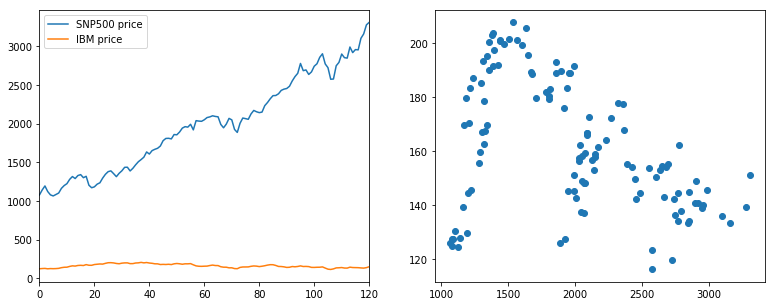

In [3]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[0])
ibm_data['Price'].plot(label = 'IBM price',ax=ax[0])
ax[0].legend()


plt.scatter(snp_data['Price'],ibm_data['Price']);

1. Оцініть за допомогою звичайного методу найменших квадратів параметри $ \alpha$ і $ \beta $ для
довільних двох компаній, що представляють дві обрані галузі. Чи відповідають оцінки вашим інтуїтивним уявленням? Чому так або чому ні?
$$y= \alpha * X+ \beta = k * X + b = slope * X + intercept = b_0 * X + b_1 = a * X + b $$

Спочатку обчислимо ціну акції IBM від індексу SNP-500

b0 = -0.0163, b1 = 194.0038, r = -0.4099, r_squared=0.1680


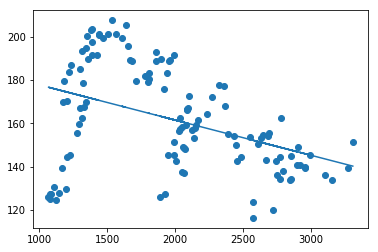

In [4]:
mlr = MyLinearRegression(snp_data.Price,ibm_data.Price)#OLS
print(str(mlr))
mlr.calculate_sp()
plt.scatter(snp_data.Price,ibm_data.Price)
plt.plot(snp_data.Price,mlr.get_pred());

In [5]:
# lr = LinearRegression()#sklearn linear model
# lr.fit(snp_data.Price.values.reshape(-1,1),ibm_data.Price.values.reshape(-1,1))
# lr.coef_[0][0],lr.intercept_[0]

2. Для кожної з компаній перевірте нульову гіпотезу про те, що $\alpha$ = 0 (у порівнянні з
альтернативною гіпотезою про те, що $\alpha \neq$ 0), використовуючи рівень значимості 5%. Чи
означає відкидання цієї нульової гіпотези, що модель ЦОК (ціноутворення на основний капітал) є невірною? Чому так або
чому ні?


In [6]:
t_value = t_val(mlr.intercept,0,mlr.sp_dict['intercept'])
t_critical = stats.t.ppf(q=1-0.025,df=ibm_data.shape[0]-2)

sign,message = evaluate_hypothesis(t_value,t_critical)

print(f'T_value = {t_value:.4f} {sign} {t_critical:.4f} = T_crit. {message}')

T_value = 28.2227 > 1.9801 = T_crit. hypothesis rejected


3. Для кожної компанії визначте довірчий інтервал (з рівнем довіри 95%) для $\beta$. Потім
перевірте гіпотезу про те що $\beta = 1$ проти альтернативної гіпотези $\beta \neq 1.$

In [7]:
t_value = t_val(mlr.slope,1,mlr.sp_dict['slope'])
t_critical = stats.t.ppf(q=1-0.025,df=ibm_data.shape[0]-2)

sign,message = evaluate_hypothesis(t_value,t_critical)

print(f'T_value = {abs(t_value):.4f} {sign} {t_critical:.4f} = T_crit. {message}')

T_value = 306.3779 > 1.9801 = T_crit. hypothesis must be examined further


In [8]:
mlr.confidence_interval(t_critical)
mlr.slope,mlr.calcualte_interval(mlr.slope,mlr.sp_dict['slope'],t_critical)

(-0.016261747607528628, (-0.02282977928875942, -0.009693715926297836))

4. За результатами аналізу вашої вибірки дайте відповідь на питання: чи дійсно великі
значення оцінок $ \beta $ відповідають більш високим значенням R2?

In [9]:
f_value = F_val(ibm_data.Price,mlr.get_pred())
f_critical = stats.f.ppf(q=1-0.025,dfn=1, dfd=ibm_data.shape[0]-2)#dfn = number_of_groups-1; #dfd = (num_of_groups-1)*(num_of_subj-1)

sign,msg = evaluate_hypothesis(f_value,f_critical)

print(f'F_value = {f_value:.4f} {sign} {f_critical:.4f} = F_crit. {msg}')

F_value = 24.0347 > 5.1534 = F_crit. hypothesis rejected


5. Зробіть прогноз на наступний рік та побудуйте довірчий інтервал

In [10]:
ibm_test_data = ibm_data.iloc[:,:].copy()
snp_test_data = snp_data.iloc[:,:].copy()

predicted = mlr.predict(snp_test_data.Price)

l,r = mlr.calcualte_interval(predicted,mlr.sp_y_pred(snp_test_data.Price,predicted),t_critical)
forecast_ci = pd.DataFrame(np.array([l,predicted,r,]).T,columns=['low','pred','high'])
forecast_ci

,low,pred,high
0,170.526511,176.466204,182.405897
1,169.900637,175.416265,180.931894
2,169.394430,174.567076,179.739722
3,170.095189,175.742638,181.390086
4,170.513716,176.444739,182.375763
...,...,...,...
116,139.610099,145.982582,152.355066
117,136.197733,143.551940,150.906146
118,134.904654,142.630874,150.357094
119,132.231859,140.727031,149.222202


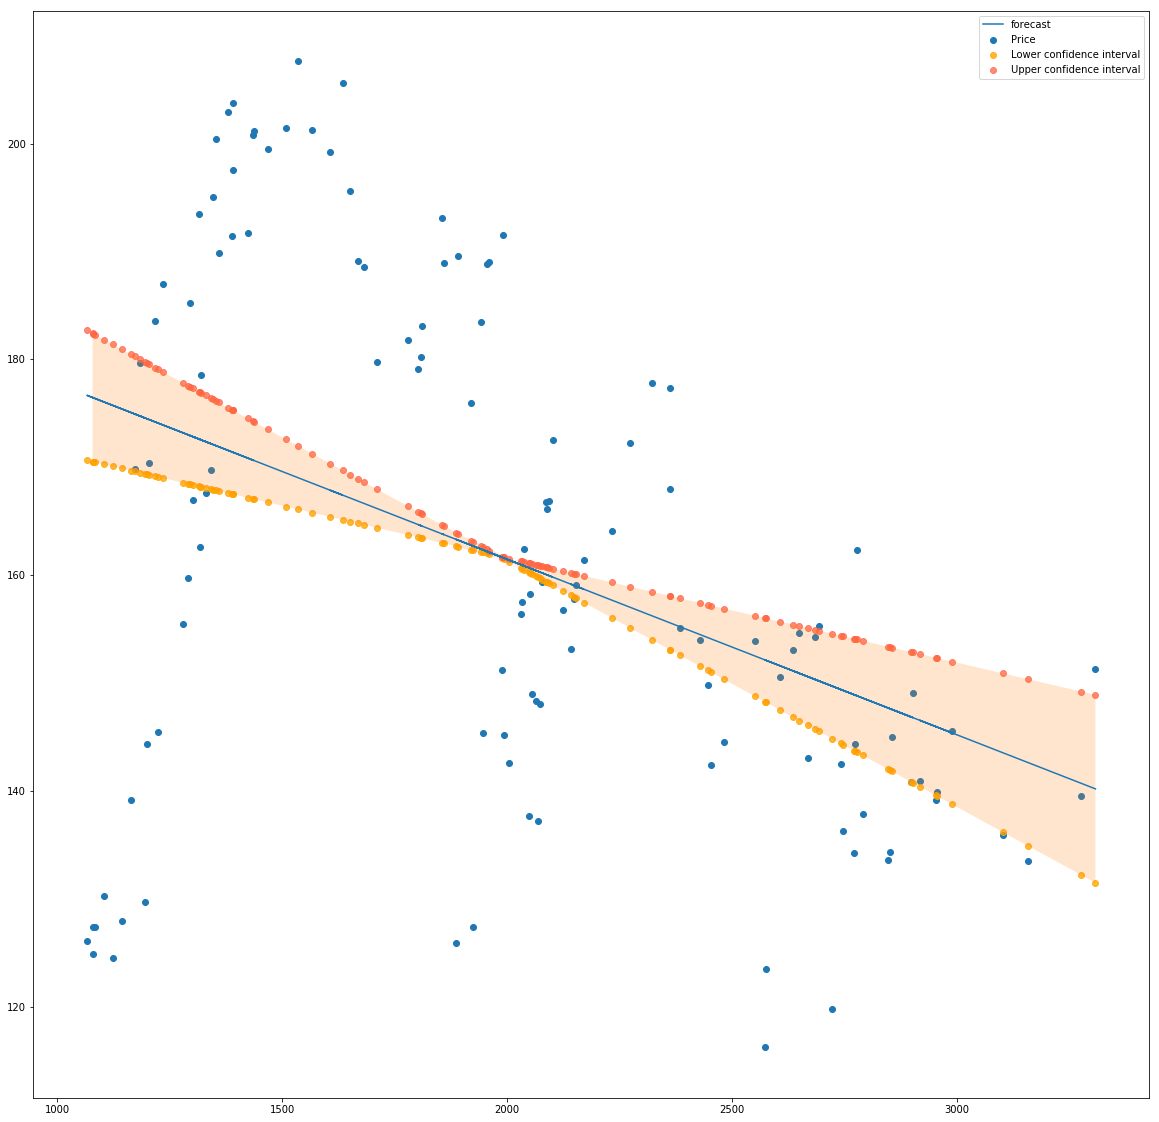

In [11]:
plt.figure(figsize=(20,20))

plt.plot(snp_test_data.Price,predicted,label='forecast')
plt.scatter(snp_test_data.Price,ibm_test_data.Price)

plt.scatter(snp_test_data.Price, forecast_ci['low'],alpha=0.8,color='orange',label='Lower confidence interval')
plt.scatter(snp_test_data.Price,forecast_ci['high'],alpha=0.75,c='tomato',label='Upper confidence interval')
plt.fill_between(snp_test_data.Price,forecast_ci['low'],forecast_ci['high'],alpha=0.2)
plt.legend();